In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# user defined modules
import calculate#, plot
from calculate import gini, hhi, percentage_zeros, gini_nonzero
from credible_authors_ import DataStore

import warnings
warnings.filterwarnings("ignore")

# Configuration - needed?
gini_nonzero.display_name = 'Gini without zeroes'
percentage_zeros.display_name = 'Percentage of zeroes'
np.mean.display_name = 'Average'

START_YEAR = 1970
LAST_START_YEAR = 2000

In [ ]:
from importlib import reload
reload(calculate)
reload(plot)

In [3]:
color_full = ['#000000', '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']
color_pale = ['#7f7f7f', '#f18c8d', '#9bbedb', '#a6d7a4', '#cba6d1', '#ffbf7f', '#ffff99', '#d2aa93', '#fbc0df', '#cccccc']

## Load data from csv

In [ ]:
data_store = DataStore()
all_papers_num_cit = data_store.all_papers_num_cit

In [ ]:
author_order = pd.read_csv('derived-data/publication_authors_order_2017.csv')

In [25]:
credible_authors = pd.read_csv('derived-data/authors-scientific-extended.csv')

### Window counts

Load in citation window data:

In [33]:
WINDOW_SIZE = 3
citations_window = pd.read_csv(f'derived-data/citations_window_{WINDOW_SIZE}.csv')
citations_window.head()

,year,author,start_year,end_year,gender,career_age,career_duration,cit_3,num_pub,win_num_pub,num_cit,cum_num_cit,cum_num_pub
0,1970,donald g. frantz,1970,1970,m,1,1,0.0,1.0,1.0,0.0,0.0,1.0
1,1970,j. raamot,1970,1972,none,1,3,0.0,1.0,2.0,0.0,0.0,1.0
2,1970,ingrid kahlert-warmbold,1970,1970,f,1,1,0.0,1.0,1.0,0.0,0.0,1.0
3,1970,n. prasad,1970,2017,f,1,48,0.0,1.0,1.0,0.0,0.0,1.0
4,1970,leonard p. sasso jr.,1970,1975,m,1,6,0.0,1.0,1.0,0.0,0.0,1.0


In [34]:
citations_window_first = pd.read_csv(f'derived-data/citations_window_{WINDOW_SIZE}_first.csv')
citations_window_first.head()

,year,author,start_year,end_year,gender,career_age,career_duration,cit_3,num_pub,win_num_pub,num_cit,cum_num_cit,cum_num_pub
0,1970,donald g. frantz,1970,1970,m,1,1,0.0,1.0,1.0,0.0,0.0,1.0
1,1970,j. raamot,1970,1972,none,1,3,0.0,1.0,2.0,0.0,0.0,1.0
2,1970,ingrid kahlert-warmbold,1970,1970,f,1,1,0.0,0.0,0.0,0.0,0.0,0.0
3,1970,n. prasad,1970,2017,f,1,48,0.0,0.0,0.0,0.0,0.0,0.0
4,1970,leonard p. sasso jr.,1970,1975,m,1,6,0.0,1.0,1.0,0.0,0.0,1.0


In [35]:
citations_window = citations_window.merge(credible_authors[['author', 'dropped_after_10']], on='author', how='left')

In [36]:
counts = citations_window

### Citations and uncited papers
Dataset with all the citations to papers, together with papers that received no citations (cit_id is null)

In [ ]:
uncited_papers_network = data_store.authorPublicationData.merge(data_store.authorCitationsData, left_on='pub_id',
                                                                     right_on='id2', how='left',
                                                                     suffixes=('_pub', '_cit'))

In [ ]:
# by merging here on 'inner', we remove duplicates with many authors
uncited_papers_network_first_auth = uncited_papers_network.merge(author_order[['first_author', 'pub_id']], 
                                                                 left_on=['author', 'pub_id'], 
                                                                 right_on=['first_author', 'pub_id'],how='inner')

In [ ]:
# add start year
uncited_papers_network_first_auth = uncited_papers_network_first_auth.merge(data_store.credible_authors[
    ['author', 'start_year']], on='author', how='left')

In [ ]:
uncited_papers_network_first_auth.drop('id2', axis='columns', inplace=True)
uncited_papers_network_first_auth.rename({'id1':'cit_id'}, axis='columns', inplace=True)

In [ ]:
career_len = data_store.credible_authors[['author', 'career_length']]
# career_len_10 = career_len[career_len['career_length'] >= 10]

### UnCited papers network - first author

In [ ]:
# uncited_papers_network_first_auth
# author == first_author
# contains all papers, with their first authors. 
# duplicate rows for pub_id are different citations, with cit_id for the citing paper
# cit_id == NaN -> paper never cited
uncited_papers_network_first_auth.head()

In [ ]:
# aggregate citations, and get the count - per author, per year pub, per paper, per year cited
auth_year_pub_cit_count = uncited_papers_network_first_auth.groupby(
    ['author', 'year_pub', 'pub_id', 'year_cit']).agg({'cit_id': 'count'})
auth_year_pub_cit_count = auth_year_pub_cit_count.reset_index()

In [ ]:
# add start year
auth_year_pub_cit_count = auth_year_pub_cit_count.merge(data_store.credible_authors[['author', 'start_year']], 
                                                        on='author', how='left')

In [ ]:
# remove cited before published. Could be right, but makes the graphs weird
auth_year_pub_cit_count = auth_year_pub_cit_count[auth_year_pub_cit_count.year_cit >= auth_year_pub_cit_count.year_pub]

In [ ]:
# take the best paper in a specific year cited
agg_cit_per_auth_year = auth_year_pub_cit_count.groupby(['start_year', 'author', 'year_pub', 'year_cit']).agg(
    {'cit_id': 'max'}).reset_index()

In [ ]:
# take the average in a specific year cited
agg_cit_per_auth_year_avg = auth_year_pub_cit_count.groupby(['start_year', 'author', 'year_pub', 'year_cit']).agg(
    {'cit_id': 'mean'}).reset_index()

In [ ]:
# veryfied this df for correctness with a different calc method
cohort_size_first_auth = uncited_papers_network_first_auth.groupby('start_year')['author'].nunique()
cohort_size_first_auth = cohort_size_first_auth.reset_index()
cohort_size_first_auth.rename({'author':'cohort_size'}, axis=1, inplace=True)

In [ ]:
# add start year
agg_cit_per_auth_year = agg_cit_per_auth_year.merge(cohort_size_first_auth, on='start_year', how='left')
agg_cit_per_auth_year_avg = agg_cit_per_auth_year_avg.merge(cohort_size_first_auth, on='start_year', how='left')

In [ ]:
agg_cit_per_auth_year = agg_cit_per_auth_year[(agg_cit_per_auth_year.start_year >= 1970) &
                                              (agg_cit_per_auth_year.start_year <=2000)]
agg_cit_per_auth_year_avg = agg_cit_per_auth_year_avg[(agg_cit_per_auth_year_avg.start_year >= 1970) &
                                              (agg_cit_per_auth_year_avg.start_year <=2000)]

#### Data interrogation 

In [ ]:
uncited_papers_network_first_auth.dropna().cit_id.count()

In [ ]:
uncited_papers_network_first_auth.year_pub.min()

In [ ]:
# author_order[author_order.pub_id == 'a43af2b6-93e5-480f-9678-8394483315a8']
uncited_papers_network_first_auth[uncited_papers_network_first_auth.pub_id == 'a43af2b6-93e5-480f-9678-8394483315a8']

In [ ]:
uncited_papers_network_first_auth['pub_id'].nunique()

In [ ]:
auth_year_pub_cit_count[(auth_year_pub_cit_count.start_year == 1999) & 
                        (auth_year_pub_cit_count.year_pub == 1999) &
#                         (auth_year_pub_cit_count.year_cit == 1999) &
                        (auth_year_pub_cit_count.author == 'joseph mitola iii')].sort_values('year_cit')

In [ ]:
# these numbers are right, according to the combined df in 0.Data Preproc.
# this means i am grabbing all the citations by all the papers, and that the filters are fixed
agg_cit_per_auth_year[(agg_cit_per_auth_year.start_year == 1999) & 
                        (agg_cit_per_auth_year.year_pub == 1999) &
#                         (agg_cit_per_auth_year.year_cit == 1999) &
                        (agg_cit_per_auth_year.author == 'joseph mitola iii')].sort_values('year_cit')

In [ ]:
# number of first authors in 1994
uncited_papers_network_first_auth[uncited_papers_network_first_auth.start_year == 1994]['author'].nunique()

In [ ]:
agg_cit_per_auth_year[(agg_cit_per_auth_year.start_year == 1994)]['author'].nunique()# & (agg_cit_per_auth_year.year_cit == 1994)]

In [ ]:
# i guess also all authors in 1994
auths_1994 = agg_cit_per_auth_year[(agg_cit_per_auth_year.start_year == 1994) & 
                      (agg_cit_per_auth_year.year_cit == 1994)]['author'].unique()
print(auths_1994.shape)

In [ ]:
author_order = author_order.merge(data_store.credible_authors[
    ['author', 'start_year']], left_on='first_author', right_on='author', how='left')

In [ ]:
# all first authors in 1994
all_auths_1994 = author_order[author_order.start_year==1994]['author'].unique()
print(all_auths_1994.shape)

### top k percent 

In [ ]:
agg_cit_per_auth_year['cit_id'] = agg_cit_per_auth_year['cit_id'].astype(int)

In [ ]:
# TODO: Flaw: array is not full. Taking k percent of non zeros. Add the missing zeros
def perc_owned_by_top_k(arr, size, k):
    arr = arr.values
    top_k = int(round((size/100)*k))
    return sum(arr[arr.argsort()[-top_k:]])/sum(arr)

In [ ]:
k=1
perc_owned = agg_cit_per_auth_year.groupby(['start_year', 'year_pub', 'year_cit'])['cit_id', 'cohort_size'].apply(
    lambda x: perc_owned_by_top_k(x['cit_id'], x['cohort_size'].max(), k)).reset_index()
perc_owned.rename({0: 'perc_owned'}, axis=1, inplace=True)

In [ ]:
data = perc_owned
metric = 'perc_owned'
for start_year in data.start_year.unique()[-10::2]:
    cohort_data = data[data.start_year == start_year]
    for year_pub in cohort_data.year_pub.unique()[:11:3]:
        one_year = cohort_data[cohort_data.year_pub == year_pub]
        plt.plot(range(0,5), one_year[metric][:5], label=f'Pubs in {year_pub}')
    plt.ylabel(f'Percent of citations held by top {k}perc')
    plt.xlabel('T - time after publishing')
    plt.title(f'Cohort start year: {start_year}')
    plt.legend()
    plt.show()

### gini

In [ ]:
def gini_expand(arr, size):
#     print(len(arr), size)
    num_zer = size - len(arr)
    arr_full = np.append(arr, np.zeros(num_zer))
    return gini(arr_full)

In [ ]:
def get_expanded_gini_df(data):
    df_gini = data.groupby(['start_year', 'year_pub', 'year_cit'])['cit_id', 'cohort_size'].apply(
        lambda x: gini_expand(x['cit_id'], x['cohort_size'].max())).reset_index()
    df_gini.rename({0: 'gini'}, axis=1, inplace=True)
    return df_gini

In [ ]:
df_gini_max = get_expanded_gini_df(agg_cit_per_auth_year)
df_gini_avg = get_expanded_gini_df(agg_cit_per_auth_year_avg)

df_gini_max['career_age'] = df_gini_max['year_pub'] - df_gini_max['start_year'] + 1
df_gini_avg['career_age'] = df_gini_avg['year_pub'] - df_gini_avg['start_year'] + 1

The inequality is very big because of the granularity of this chart. 
We first divide people into cohorts. Then for different career agees, we divide the paper's citations across Time after publishing, T. This makes the data very sparse, and we end up with a huge number of zeroes. <br>
Example: <br>
Published in 1991, cited in 1992 and 1995 <br>
Array: [0, X, 0, 0, Y]

In [ ]:
def plot_ineq_(data, metric, ext):
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    i = 0
    flat_axes = list(axs.flat)
    for start_year in [1970, 1980, 1990, 2000]:
        ax = flat_axes[i]
        cohort_data = data[data.start_year == start_year]
        for year_pub in cohort_data.year_pub.unique()[:11:3]:
            one_year = cohort_data[cohort_data.year_pub == year_pub]
            ax.plot(range(0,5), one_year[metric][:5], label=f'Career age {year_pub-start_year+1}')
        ax.set_title(f'Cohort start year: {start_year}')
        ax.legend()
        i+=1
    for ax in axs.flat:
        ax.set(xlabel='T - time after publishing', ylabel='Gini over citations')
    fig.suptitle(f"Aggregation metric: {ext}")
    fig.savefig(f'./fig-7-notebook/first_auth_ineq_gini_{ext}.pdf')
    fig.show()
# plot_ineq_(df_gini_max, 'gini', 'max')
# plot_ineq_(df_gini_avg, 'gini', 'avg')

In [ ]:
# 5 year df for max
df_gini_max_y5 = df_gini_max[df_gini_max.year_cit == df_gini_max.year_pub + 4]
career_ages = [1,2,4,7,10]
df_gini_max_y5 = df_gini_max_y5[df_gini_max_y5['career_age'].isin(career_ages)]

In [ ]:
# 5 year df for max
df_gini_avg_y5 = df_gini_avg[df_gini_avg.year_cit == df_gini_avg.year_pub + 4]
career_ages = [1,2,4,7,10]
df_gini_avg_y5 = df_gini_avg_y5[df_gini_avg_y5['career_age'].isin(career_ages)]

In [ ]:
def plot_first_auth_ineq_gini(data_df, param):
    career_ages = [1,2,4,7,10]
    career_ages = [str(x) for x in career_ages]
    start_years_gini = [1970, 1980, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999]
    data = data_df[data_df.start_year.isin(start_years_gini)]

    fig, axs = plt.subplots(2, 6, sharex='col', sharey='row',
                            gridspec_kw={'hspace': 0, 'wspace': 0}, figsize=(15,7))

    ax_outside = fig.add_subplot(111, frameon=False)
    ax_outside.grid(False)
    ax_outside.axes.get_xaxis().set_ticks([])
    ax_outside.axes.get_yaxis().set_ticks([])

    markers = ['o', 'x', '.', '+', '^']

    for ax, year in zip(axs.flat, start_years_gini):
        x = list(range(5))
        y = data[data.start_year == year]['gini']
        for marker, x_pos, y_val in zip(markers, x, y):
            ax.scatter(x_pos, y_val, marker=marker, label=f'Career age {career_ages[x_pos]}')
        ax.set_xlabel(year)
        ax.set_xticks(x)

    for ax in axs.flat:
    #     ax.label_outer()
        ax.grid(False)
        ax.set_xticklabels(career_ages)
    for ax in axs.flat[:6]:
        ax.xaxis.set_label_position('top') 
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc=(0.84,0.22))

    ax_outside.set_xlabel('Cohort start year', labelpad=50, fontweight='bold')
    ax_outside.set_ylabel(f'Gini inequality five years after publishing - {param.upper()}', labelpad=50, fontweight='bold')
    fig.savefig(f'./fig-7-notebook/first_auth_ineq_gini_{param}_squeze.pdf')
plot_first_auth_ineq_gini(df_gini_max_y5, 'avg')
plot_first_auth_ineq_gini(df_gini_max_y5, 'max')

### Cliffs Delta

In [ ]:
cum_cit_pub_agg_first = citations_window_first.groupby(['start_year', 'career_age', 'gender']).agg({
    'cum_num_pub_first': list,
    'cum_num_cit_first': list
}).reset_index()

cum_cit_pub_agg = citations_window.groupby(['start_year', 'career_age', 'gender']).agg({
    'cum_num_pub': list,
    'cum_num_cit': list
}).reset_index()

In [ ]:
def get_cohort_effect_size(cohort_careerage_df, metric, gen_a='m', gen_b='f', eff_form='r'):
    data = cohort_careerage_df[cohort_careerage_df.gender.isin([gen_a, gen_b])]
    data = data.set_index(['start_year', 'career_age', 'gender']).unstack(level=-1)
    data.columns = ['_'.join(col) for col in data.columns]
    data['cliffd_m_f'] = data.apply(lambda x: calculate.cliffsD(x[f'{metric}_{gen_a}'], x[f'{metric}_{gen_b}']), axis=1)
    mwu = data.apply(lambda x: calculate.mann_whitney_effect_size(
        x[f'{metric}_{gen_a}'], x[f'{metric}_{gen_b}'], effect_formula=eff_form), axis=1).apply(pd.Series)
    mwu.columns = ['effect', 'statistic', 'pvalue']
    data = data.join(mwu)
    data = data[['cliffd_m_f', 'effect', 'statistic', 'pvalue']]
    data = data.reset_index()
    return data

In [ ]:
a = [1,2,3,4,5,6]
a[1::2]

In [ ]:
def plot_cohort_diffs_over_ages(stats, criterion, criterion_display, ext=''):
    # x - career age
#     plt = plot.init_plotting()
    i = 0  # to point to the right figure
    j = 0

    # rearange subplots dynamically
    cols = 3
    cohort_start_years = np.unique(stats["start_year"].values)
    # remove 1970 from plot
    cohort_start_years = cohort_start_years[1:]
    # remove every second year
    cohort_start_years = cohort_start_years[1::2]
    # 15 cohorts
    if (len(cohort_start_years) > 20):
        cols = 6

    nrows = math.ceil(float(len(cohort_start_years)) / float(cols))
    nrows = int(nrows)

    fig3, ax3 = plt.subplots(nrows, cols, sharex=True, sharey=True, figsize=(7, 10))  # sharey=True,
    # Create a big subplot to created axis labels that scale with figure size
    ax_outside = fig3.add_subplot(111, frameon=False)
    ax_outside.grid(False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    ax_outside.set_xlabel('Career Age', labelpad=20, fontweight='bold')
    ax_outside.set_ylabel(f'Cliffs Delta m-f {criterion_display}', labelpad=20, fontweight='bold')

    for year in cohort_start_years:
        cohort = stats[stats["start_year"] == year]
        significant_effect = cohort[cohort.pvalue <= 0.05].career_age.values
        significant_effect = [index - 1 for index in significant_effect]

        ax3[i, j].plot(cohort["career_age"], cohort["cliffd_m_f"].values, '-D', markevery=significant_effect)
        ax3[i, j].set_title(f"{year} ({len(significant_effect)})", fontsize=12, fontweight="bold")
        # ax3[i,j].grid(True)

        if (j < cols - 1):
            j = j + 1
        else:
            j = 0
            i = i + 1

    fig3.savefig(f"./fig-7-notebook/{criterion}{ext}_gender.png", facecolor=fig3.get_facecolor(), edgecolor='none',
                 bbox_inches='tight')
    plt.tight_layout()
    plt.show()
    plt.close(fig3)

In [ ]:
mwu_cliff_d_cum_pub_first = get_cohort_effect_size(cum_cit_pub_agg_first, 'cum_num_pub_first')
mwu_cliff_d_cum_cit_first = get_cohort_effect_size(cum_cit_pub_agg_first, 'cum_num_cit_first')

mwu_cliff_d_cum_pub = get_cohort_effect_size(cum_cit_pub_agg, 'cum_num_pub')
mwu_cliff_d_cum_cit = get_cohort_effect_size(cum_cit_pub_agg, 'cum_num_cit')

In [ ]:
# pubs
plot_cohort_diffs_over_ages(mwu_cliff_d_cum_pub_first, 'mwu_cliffsd_cum_pub', 'Cumulative publications first auth', ext='_first')
plot_cohort_diffs_over_ages(mwu_cliff_d_cum_pub, 'mwu_cliffsd_cum_pub', 'Cumulative publications')

# cit
plot_cohort_diffs_over_ages(mwu_cliff_d_cum_cit_first, 'mwu_cliffsd_cum_cit', 'Cumulative citations first auth', ext='_first')
plot_cohort_diffs_over_ages(mwu_cliff_d_cum_cit, 'mwu_cliffsd_cum_cit', 'Cumulative citations')

## Inequality of papers

In [ ]:
def plot_ineq_papers_cohort(cohort_year, years_in_future=5, career_ages=[0,1,2,5,10], func=gini,
                           data=uncited_papers_network_first_auth):
    
    uncited_papers_network_cohort = data[data['start_year'] 
                                                                          == cohort_year]
    paper_cited_list = uncited_papers_network_cohort.groupby(['year_pub', 'pub_id']).agg({'year_cit': list})
    for career_year in [cohort_year + ca for ca in career_ages]:
#         print(f"Career year {career_year}")
        paper_cited_list_year = paper_cited_list.loc[career_year]
#         print('Cited in: ', end=' ')
        for i in range(career_year,career_year+years_in_future):
            paper_cited_list_year[f'cit_in_{i}'] = paper_cited_list_year['year_cit'].apply(lambda x: sum(list(map(lambda y: 
                                                                                                                  y==i, x))))
#             print(i, end=' ')
#         print(paper_cited_list_year.columns)
        ginis = [func(paper_cited_list_year[col].astype(float).values) for col in paper_cited_list_year.columns[1:]]
#         print(ginis)
        plt.plot(ginis, label=f'{career_year-cohort_year}')
    plt.xlabel('Years after publishing')
    if func.__name__ == 'gini': 
        ylab = 'Gini in Recognition'
    else:
        ylab = func.display_name
    plt.ylabel(ylab)
    plt.legend(title='Career age when published')
    plt.title(f'Paper inequality for Cohort: {cohort_year}')
    plt.show()

### Authors with career len > 10

In [ ]:
# plot_ineq_papers_cohort(2000, 5, func=percentage_zeros, data=uncited_papers_network_first_auth_10)

In [ ]:
# plot_ineq_papers_cohort(2000, 5, func=gini, data=uncited_papers_network_first_auth_10)

In [ ]:
# plot_ineq_papers_cohort(2000, 5, func=gini_nonzero, data=uncited_papers_network_first_auth_10)

### All authors

In [ ]:
plot_ineq_papers_cohort(2000, 5, func=percentage_zeros)
plot_ineq_papers_cohort(2000, 5, func=gini_nonzero)
plot_ineq_papers_cohort(2000, 5, func=gini)

In [ ]:
plot_ineq_papers_cohort(2000, 5, func=np.mean)

## Cohort Sizes

In [ ]:
cohort_sizes = counts.groupby('start_year').agg({'author': 'nunique'})

In [ ]:
def plot_cohort_size_over_years():
    linewidth = 2
    fontsize = 18
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    ax.plot(cohort_sizes.index, cohort_sizes.values, linewidth=linewidth, color='black')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.set_yscale('log')
    ax.set_xlabel('Cohort', fontsize=fontsize)
    ax.set_ylabel('Number of Authors', fontsize=fontsize)
    #ax.set_title('', fontsize=fontsize)
    ax.set_xticks([1970, 1980, 1990, 2000])
    ax.tick_params(axis="x", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize, pad=7)
    ax.tick_params(axis="x", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize, pad=7)
    ax.tick_params(axis="y", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize)
    ax.tick_params(axis="y", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['top'].set_linewidth(linewidth)
    #ax.legend(fontsize=fontsize)
    plt.gcf().text(0., 0.9, 'A', fontsize=fontsize*2)
    plt.subplots_adjust(left=0.25, right=0.95, bottom=0.2, top=0.9)
    fig.savefig('./fig-7-notebook/cohort_size.pdf')
plot_cohort_size_over_years()

## Make plot

In [37]:
def plot_criteria_over_career_ages(data, criteria, criteria_name, title, letter, x_start=1, x_end=15, legend=True, name_ext=''):
    linewidth = 2
    fontsize = 18
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    color = ['#000000', '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']
    cohort = [1970, 1975, 1980, 1985, 1990, 1995, 2000]
    for i in range(0, 7):
        df = data[data['start_year'] == cohort[i]]
        df = df[(df['career_age'] >= x_start) & (df['career_age'] <= x_end)]
        ax.plot(df['career_age'], df[criteria], linewidth=linewidth, label=cohort[i], color=color[i])
    ax.set_xlim([0.25, 15.75])
    ax.set_ylim([-0.05, 1.05])
    if 'gini' in criteria:
        ax.set_ylim([-0.05, 1.05])
    if 'hhi' in criteria:
        ax.set_ylim([-0.004, 0.074])
    if 'pzero' in criteria:
        ax.set_ylim([-0.05, 1.05])
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.set_xlabel('Career Age', fontsize=fontsize)
    ax.set_ylabel(f'{criteria_name}', fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.set_xticks([1, 5, 10, 15])
    ax.tick_params(axis="x", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize, pad=7)
    ax.tick_params(axis="x", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize, pad=7)
    ax.tick_params(axis="y", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize)
    ax.tick_params(axis="y", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['top'].set_linewidth(linewidth)
    if legend: ax.legend(fontsize=fontsize-6)
    plt.gcf().text(0., 0.9, letter, fontsize=fontsize*2)
    plt.subplots_adjust(left=0.25, right=0.95, bottom=0.2, top=0.9)
    fig.savefig(f'./fig-7-notebook/{criteria}{name_ext}.pdf')
    
def plot_heatmap(data, publish_years, crit):
    data_matrix = data.groupby('career_age').agg({f'ec_cit_{start}_{end}{crit}': 'mean' for start,end in publish_years})
    data_matrix[data_matrix < 0.0001] = None
    sns.heatmap(data_matrix.T[::-1], cmap="YlGnBu")

In [38]:
def agg_data_df(citations_window, func, func_name):
    cohort_counts_ = citations_window.groupby(['start_year', 'career_age']).agg({
    'cum_num_pub':func, 'cum_num_cit':func, 'win_num_pub':func})
    # remove people not competing for attention
    cohort_counts__ = citations_window[citations_window['num_pub']>0].groupby(['start_year', 'career_age']).agg({
    'cit_3':func})
    cohort_counts_['cit_3'] = cohort_counts__['cit_3']
    cohort_counts_.reset_index(inplace=True)
    cohort_counts_ = cohort_counts_.rename({
        'cum_num_pub':f'{func_name}_cum_num_pub', 
        'cum_num_cit':f'{func_name}_cum_num_cit',
        'win_num_pub':f'{func_name}_win_num_pub',
        'cit_3': f'{func_name}_win_num_cit'
    }, axis='columns')
    return cohort_counts_

In [39]:
def plot_array_configs(data, configs, x_end=15, name_ext=''):
    legend = True
    for config in configs:
        plot_criteria_over_career_ages(data, *config, legend=legend, x_end=x_end, name_ext=name_ext)
        legend = False

In [40]:
def get_config1(crit, crit_name):
    config1 = [(f'{crit}_cum_num_pub', f'{crit_name} Productivity', 'Cumulative Counting', 'A'),
                (f'{crit}_cum_num_cit', f'{crit_name} Recognition', 'Cumulative Counting', 'C')]
    return config1

def get_config2(crit, crit_name):
    config2 = [(f'{crit}_win_num_pub', f'{crit_name} Productivity', 'Window Counting', 'B'),
                (f'{crit}_win_num_cit', f'{crit_name} Recognition', 'Window Counting', 'D')]
    return config2

In [41]:
def plot_early_late_work(author_early_work, years_list, name_ext=''):
    num_iter = len(years_list)
    crits = ['_cum', '']
    letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
    titles = ['Cum', 'Win']

    legend = True
    for i in range(0,num_iter*len(crits)):
        letter=letters[i]
        start,end = years_list[i%num_iter]
        crit = crits[i//num_iter]
        title = titles[i//num_iter]
        plot_criteria_over_career_ages(author_early_work, f'ec_cit_{start}_{end}{crit}', 'Gini Recognition', 
            title=f'{title}. (Papers of Age {start+1})', x_start=end,
            letter=letter, legend=legend, name_ext=name_ext)
        legend = False

In [42]:
def agg_data_early_late(citations_window, func, publish_years):
    aggregate = {f'ec_cit_{start}_{end}': func for start,end in publish_years}
    aggregate.update({f'ec_cit_{start}_{end}_cum': func for start,end in publish_years})

    author_early_work = citations_window[citations_window['num_pub']>0].groupby(['start_year', 'career_age']).agg(aggregate).reset_index()
    return author_early_work

## Ginis

#### First author

In [43]:
cohort_counts_gini_first = agg_data_df(citations_window_first, gini, 'gini')

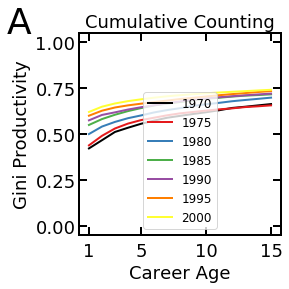

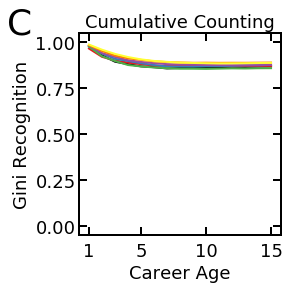

In [44]:
plot_array_configs(cohort_counts_gini_first, get_config1('gini', 'Gini'), name_ext='_first')

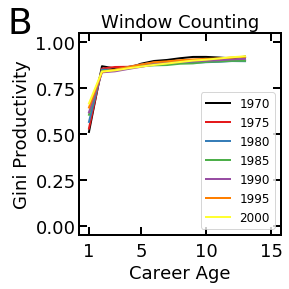

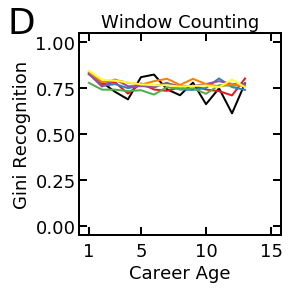

In [45]:
plot_array_configs(cohort_counts_gini_first, get_config2('gini', 'Gini'), x_end=13, name_ext='_first')

#### Cumulative and time windows

In [46]:
cohort_counts_gini = agg_data_df(citations_window, gini, 'gini')

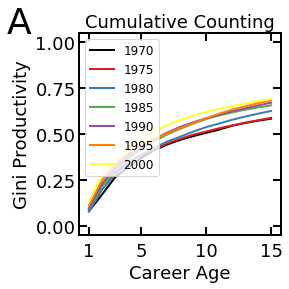

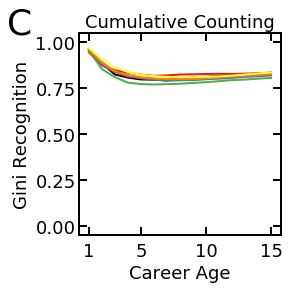

In [47]:
plot_array_configs(cohort_counts_gini, get_config1('gini', 'Gini'))

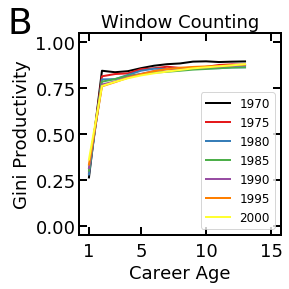

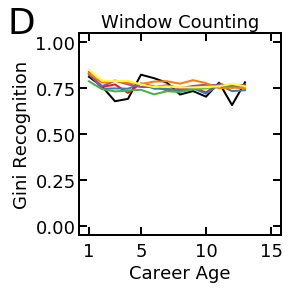

In [48]:
plot_array_configs(cohort_counts_gini, get_config2('gini', 'Gini'), x_end=13)

#### Non zero

In [ ]:
cohort_counts_gini_nonzero = agg_data_df(citations_window, gini_nonzero, 'gini_nonzero')

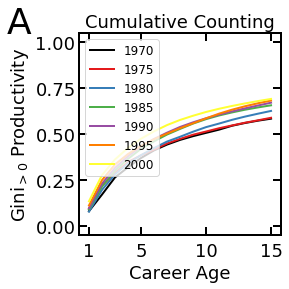

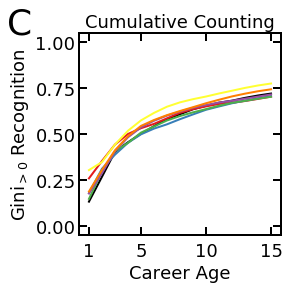

In [19]:
plot_array_configs(cohort_counts_gini_nonzero, get_config1('gini_nonzero', 'Gini$_{>0}$'))

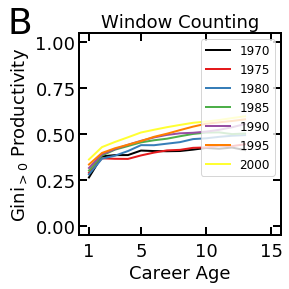

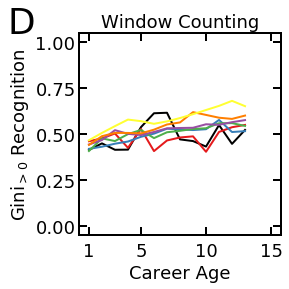

In [21]:
plot_array_configs(cohort_counts_gini_nonzero, get_config2('gini_nonzero', 'Gini$_{>0}$'), x_end=13)

#### Inequality of early vs later work

In [ ]:
# publish_years = [[0,3], [3,6], [6,9], [0,1], [3,4], [6,7]]
first_year = 0
publish_years = [[i, i+1] for i in range(first_year,15)]
author_gini_early_work = agg_data_early_late(citations_window, gini, publish_years)

In [ ]:
plot_heatmap(author_gini_early_work, publish_years, '_cum')

In [ ]:
plot_heatmap(author_gini_early_work, publish_years, '')

In [ ]:
years_list = [[0,1], [3,4], [6,7]]
plot_early_late_work(author_gini_early_work, years_list)

##### Cumulative recognition

In [ ]:
#cumulative
# for start,end in publish_years:
#     plot_criteria_over_career_ages(author_gini_early_work, f'ec_cit_{start}_{end}_cum', 'Recognition', 
#                                title=f'Publications of Career Ages {start+1}-{end} cumulative', 
#                                letter='', 
#                                x_start=end)

##### Non cumulative recognition

In [ ]:
#non cumulative
# for start,end in publish_years:
#     plot_criteria_over_career_ages(author_gini_early_work, f'ec_cit_{start}_{end}', 'Recognition', 
#                                title=f'Publications of Career Ages {start+1}-{end}', 
#                                letter='', 
#                                 x_start=end)

## HHI

In [ ]:
cohort_counts_hhi = agg_data_df(citations_window, hhi, 'hhi')

In [ ]:
plot_array_configs(cohort_counts_hhi, get_config1('hhi', 'HHI'))
plot_array_configs(cohort_counts_hhi, get_config2('hhi', 'HHI'), x_end=13)

## Percentage zeros

In [ ]:
cohort_counts_pzero = agg_data_df(citations_window, percentage_zeros, 'pzero')

In [ ]:
plot_array_configs(cohort_counts_pzero, get_config1('pzero', '%0'))

In [ ]:
plot_array_configs(cohort_counts_pzero, get_config2('pzero', '%0'), x_end=13)

## Remove dropouts

In [28]:
citations_window_stayed = citations_window[citations_window.dropped_after_10 == False]

### Gini

In [49]:
cohort_counts_stayed_gini = agg_data_df(citations_window_stayed, gini, 'gini')

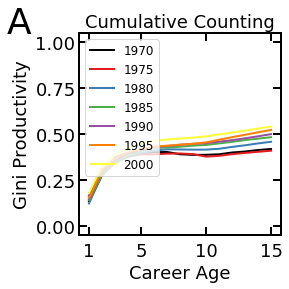

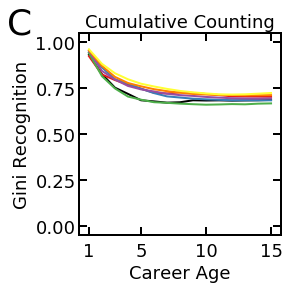

In [50]:
plot_array_configs(cohort_counts_stayed_gini, get_config1('gini', 'Gini'), name_ext='_stay') #3

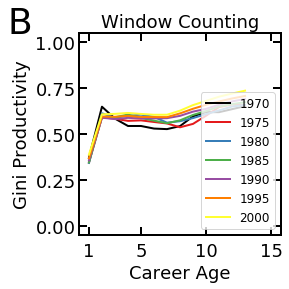

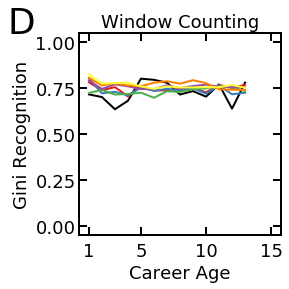

In [51]:
plot_array_configs(cohort_counts_stayed_gini, get_config2('gini', 'Gini'), x_end=13, name_ext='_stay') #3

### P zero

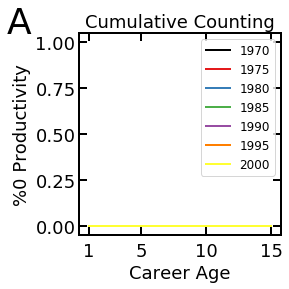

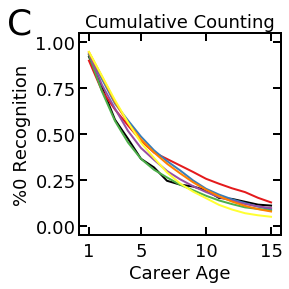

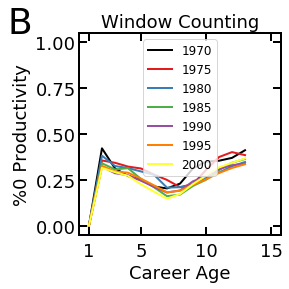

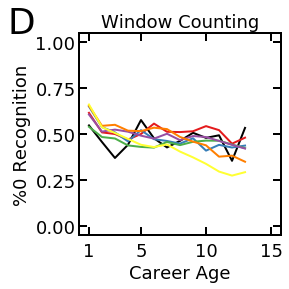

In [32]:
cohort_counts_stayed_pzero = agg_data_df(citations_window_stayed, percentage_zeros, 'pzero')
plot_array_configs(cohort_counts_stayed_pzero, get_config1('pzero', '%0'), name_ext='_stay')
plot_array_configs(cohort_counts_stayed_pzero, get_config2('pzero', '%0'), x_end=13, name_ext='_stay') #plot 5

### Early vs late

In [ ]:
# publish_years = [[0,3], [3,6], [6,9], [0,1], [3,4], [6,7]]
publish_years = [[i, i+1] for i in range(1,15)]

author_gini_early_work_stayed = agg_data_early_late(citations_window_stayed, gini, publish_years)

In [ ]:
plot_heatmap(author_gini_early_work_stayed, publish_years, '')

In [ ]:
plot_heatmap(author_gini_early_work_stayed, publish_years, '_cum')

In [ ]:
author_gini_early_work_stayed.columns

In [ ]:
years_list = [[1,2], [3,4], [6,7]]
plot_early_late_work(author_gini_early_work_stayed, years_list, name_ext='_stay')

In [ ]:
stop here

## Distributions

### Cohort Years
Cumulative numbers needed.

In [ ]:
start_year = 2000
career_age = 15
data = counts[(counts['start_year'] == start_year) & (counts['career_age'] == career_age)]['cum_num_pub']
data = data[data > 0]
#np.median(data)
#np.round(np.mean(data))

In [ ]:
# pdf='cum_num_pub_2000.pdf'
cars.fit_univariate(data, discrete=True, xmin=1, xlabel='p', title='2000', bins=24, bootstrap=None, col=1, marker='o', markersize=12, linewidth=2, fontsize=24, unbinned_data=True, pdf=None, png=None)

In [ ]:
#guys from 2000 cohort with more than 300 papers
counts[(counts['start_year'] == 2000) & (counts['career_age'] == 15) & (counts['cum_num_pub'] > 300)][['author', 'cum_num_pub']]

### Years

In [ ]:
# publications produced between 1971 and 2014
#p = list(counts[counts['year'].between(1971, 2014)][['author', 'num_pub']].groupby('author').sum().reset_index(drop=True)['num_pub'])
# publications by all authors from cohorts 1971 to 2000 produced in their first 15 years
p = list(counts[(counts['start_year'].between(1971, 2000)) & (counts['career_age'].between(1, 15))][['author', 'num_pub']].groupby('author').sum().reset_index(drop=True)['num_pub'])
p = [int(x) for x in p if x>0]

In [ ]:
# citations received between 1971 and 2014
#c = list(counts[counts['year'].between(1971, 2014)][['author', 'num_cit']].groupby('author').sum().reset_index(drop=True)['num_cit'])
# citations received by all authors from cohorts 1971 to 2000 in their first 15 years
c = list(counts[(counts['start_year'].between(1971, 2000)) & (counts['career_age'].between(1, 15))][['author', 'num_cit']].groupby('author').sum().reset_index(drop=True)['num_cit'])
c = [int(x) for x in c if x>0]

In [ ]:
import compsoc as cs

In [ ]:
parameters_p, test_statistics_p = cs.fit_power_law(l=p, discrete=True, xmin=1, fit=None, sims=None, bootstrap=None, data_original=False, markersize=9, linewidth=2, fontsize=18, marker=0, color=1, xlabel='p', title='', legend=False, letter='', Pdf=None, png=None)

In [ ]:
parameters_c, test_statistics_c = cs.fit_power_law(l=c, discrete=True, xmin=1, fit=None, sims=None, bootstrap=None, data_original=False, markersize=9, linewidth=2, fontsize=18, marker=0, color=2, xlabel='c', title='', legend=False, letter='', Pdf=None, png=None)

In [ ]:
a_bin_p = cs.bin_pdf(cs.pdf(p))
a_bin_c = cs.bin_pdf(cs.pdf(c))

In [ ]:
import powerlaw as pl

In [ ]:
f_p = pl.Fit(p, discrete=True, xmin=1)
f_c = pl.Fit(c, discrete=True, xmin=1)

In [ ]:
space_xmin_p = np.logspace(np.log10(f_p.xmin), np.log10(max(f_p.data_original)), 100)
space_xmin_c = np.logspace(np.log10(f_c.xmin), np.log10(max(f_c.data_original)), 100)
scale_p = f_p.n_tail/len(f_p.data_original)
scale_c = f_c.n_tail/len(f_c.data_original)

In [ ]:
fontsize = 18
linewidth = 2
markersize = 9
color_full = ['#000000', '#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']
color_pale = ['#7f7f7f', '#f18c8d', '#9bbedb', '#a6d7a4', '#cba6d1', '#ffbf7f', '#ffff99', '#d2aa93', '#fbc0df', '#cccccc']
fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_subplot(111)
ax1.plot(a_bin_p[:, 0], a_bin_p[:, 3], marker='o', color='#e41a1c', ls='', markersize=markersize, label='$x=p$')
ax1.plot(a_bin_c[:, 0], a_bin_c[:, 3], marker='o', color='#377eb8', ls='', markersize=markersize, label='$x=c$')
ax1.plot(space_xmin_p, scale_p*f_p.truncated_power_law.pdf(space_xmin_p), color='k', ls='-', linewidth=linewidth)
ax1.plot(space_xmin_c, scale_c*f_c.lognormal.pdf(space_xmin_c), color='k', ls='--', linewidth=linewidth)
ax1.xaxis.set_ticks_position('both')
ax1.yaxis.set_ticks_position('both')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('$x$', fontsize=fontsize)
ax1.set_ylabel('$p(x)$', fontsize=fontsize)
ax1.set_xticks([1, 10, 100, 1000, 10000])
ax1.tick_params(axis="x", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize, pad=7)
ax1.tick_params(axis="x", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize, pad=7)
ax1.tick_params(axis="y", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize)
ax1.tick_params(axis="y", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize)
ax1.spines['left'].set_linewidth(linewidth)
ax1.spines['right'].set_linewidth(linewidth)
ax1.spines['bottom'].set_linewidth(linewidth)
ax1.spines['top'].set_linewidth(linewidth)
ax1.legend(fontsize=fontsize-6)
plt.gcf().text(0., 0.9, 'B', fontsize=fontsize*2)
plt.subplots_adjust(left=0.25, right=0.95, bottom=0.2, top=0.9)
fig.savefig('./fig-7-notebook/distributions.pdf')
plt.show()

In [ ]:
year = 2014
p = counts[counts['year'] == year]['cum_num_pub']
p = p[p > 0]
#np.median(p)
#np.round(np.mean(p))

In [ ]:
# pdf='years_cum_num_pub_2014.pdf'
cars.fit_univariate(p, discrete=True, xmin=1, xlabel='p', title=None, bins=24, bootstrap=None, col=1, marker='o', markersize=12, linewidth=2, fontsize=18, unbinned_data=True, pdf='years_cum_num_pub_2014.pdf', png='years_cum_num_pub_2014.png')

In [ ]:
pubids = authorPublicationData.pub_id.tolist()

In [ ]:
df_citations = pd.read_csv('data/paper_venue_citations.csv', sep='\t')

In [ ]:
df_citations = df_citations[df_citations.year.between(1970, 2014)]
df_citations = df_citations[df_citations.paper2.isin(pubids)]

In [ ]:
c = df_citations.groupby(['venue2']).size()

In [ ]:
### pdf='years_cum_num_cit_2014.pdf'
cars.fit_univariate(c, discrete=True, xmin=(1, 10), xlabel='c', title=None, bins=24, bootstrap=None, col=2, marker='o', markersize=12, linewidth=2, fontsize=18, unbinned_data=True, pdf='bradford_2014.pdf', png='bradford_2014.png')

## Matthew Effect

In [ ]:
# prepare output tables
micro_stats = pd.DataFrame(columns=['t', 'dt', 'author', 'eta'])
macro_stats = pd.DataFrame(columns=['t', 'dt', 'n', 'D', 'beta', 'beta_std', 'r2', 'reduced_chi'])
# settings
dt = 5
unit = 'num_cit' # CHANGE COLOR (1) AND LETTER (5)
fit = 'odr'
for t in range(1970+dt, 2015-dt+2): # range(1975, 2012) for dt=5
    # get vectors
    t0 = counts[counts['year'].between(t-dt, t-1)][['author', unit]].groupby('author').sum()
    t1 = counts[counts['year'].between(t, t+dt-1)][['author', unit]].groupby('author').sum()
    #t1 = counts[counts['year'].between(t, t)][['author', unit]].groupby('author').sum()
    t0 = t0[t0[unit] > 0]
    t1 = t1[t1[unit] > 0]
    # merge vectors into dataframe
    ca = pd.merge(left=t0, right=t1, left_index=True, right_index=True)
    ca.columns = ['t0', 't1']
    # fit
    df_stats, df_bootstrap = cars.fit_bivariate(ca['t0'], ca['t1'], fit=fit, reduction='bin', color=2, xlabel='c_{%.0f-%.0f}' %(t-dt, t-1), ylabel='c_{%.0f-%.0f}' %(t, t+dt-1), title='', pdf='matthew/macro_c_'+fit+'Bin_t'+str(t)+'_dt'+str(dt)+'.pdf')
    # extend micro stats (fitness)
    ca['t'] = t
    ca['dt'] = dt
    ca['author'] = ca.index
    t1_exp = df_stats['D'][0]*ca['t0']**df_stats['beta'][0]
    ca['eta'] = ca['t1']/t1_exp
    ca = ca[['t', 'dt', 'author', 'eta']]
    # extend macro stats
    df_stats['t'] = t
    df_stats['dt'] = dt
    df_stats = df_stats[['t', 'dt', 'n', 'D', 'beta', 'beta_std', 'r2', 'reduced_chi']]
    # append stats
    micro_stats = pd.concat([micro_stats, ca], axis=0, ignore_index=True)
    macro_stats = pd.concat([macro_stats, df_stats], axis=0, ignore_index=True)
# write output tables
micro_stats.to_csv('matthew/micro_c_'+fit+'Bin_dt'+str(dt)+'.txt', sep='\t', index=False)
macro_stats.to_csv('matthew/macro_c_'+fit+'Bin_dt'+str(dt)+'.txt', sep='\t', index=False)

### Cumulative Advantage

In [ ]:
macro_p_olsBin_dt5 = pd.read_csv('matthew/macro_p_olsBin_dt5.txt', sep='\t')
macro_c_olsBin_dt5 = pd.read_csv('matthew/macro_c_olsBin_dt5.txt', sep='\t')

In [ ]:
macro_p_odrBin_dt5 = pd.read_csv('matthew/macro_p_odrBin_dt5.txt', sep='\t')
macro_c_odrBin_dt5 = pd.read_csv('matthew/macro_c_odrBin_dt5.txt', sep='\t')

In [ ]:
plt.fill_between(macro_p_olsBin_dt5['t'], macro_p_olsBin_dt5['beta']-macro_p_olsBin_dt5['beta_std'], macro_p_olsBin_dt5['beta']+macro_p_olsBin_dt5['beta_std'], color=color_pale[1], linewidth=0)
plt.fill_between(macro_c_olsBin_dt5['t'], macro_c_olsBin_dt5['beta']-macro_c_olsBin_dt5['beta_std'], macro_c_olsBin_dt5['beta']+macro_p_olsBin_dt5['beta_std'], color=color_pale[2], linewidth=0)
plt.plot(macro_p_olsBin_dt5['t'], macro_p_olsBin_dt5['beta'], color=color_full[1], label='Productivity')
plt.plot(macro_c_olsBin_dt5['t'], macro_c_olsBin_dt5['beta'], color=color_full[2], label='Recognition')
plt.title('Ordinary Least Squares')
plt.xlabel('Year')
plt.ylabel('Cumulative Advantage')
plt.legend()

In [ ]:
plt.fill_between(macro_p_odrBin_dt5['t'], macro_p_odrBin_dt5['beta']-macro_p_odrBin_dt5['beta_std'], macro_p_odrBin_dt5['beta']+macro_p_odrBin_dt5['beta_std'], color=color_pale[1], linewidth=0)
plt.fill_between(macro_c_odrBin_dt5['t'], macro_c_odrBin_dt5['beta']-macro_c_odrBin_dt5['beta_std'], macro_c_odrBin_dt5['beta']+macro_p_odrBin_dt5['beta_std'], color=color_pale[2], linewidth=0)
plt.plot(macro_p_odrBin_dt5['t'], macro_p_odrBin_dt5['beta'], color=color_full[1], label='Productivity')
plt.plot(macro_c_odrBin_dt5['t'], macro_c_odrBin_dt5['beta'], color=color_full[2], label='Recognition')
plt.title('Orthogonal Distance Regression')
plt.xlabel('Year')
plt.ylabel('Cumulative Advantage')
plt.legend()

### Fitness

In [ ]:
micro_p_olsBin_dt5 = pd.read_csv('matthew/micro_p_olsBin_dt5.txt', sep='\t')
micro_c_olsBin_dt5 = pd.read_csv('matthew/micro_c_olsBin_dt5.txt', sep='\t')

In [ ]:
micro_p_odrBin_dt5 = pd.read_csv('matthew/micro_p_odrBin_dt5.txt', sep='\t')
micro_c_odrBin_dt5 = pd.read_csv('matthew/micro_c_odrBin_dt5.txt', sep='\t')

Users with long careers:

In [ ]:
micro_p_olsBin_dt5.groupby('author').count()

In [ ]:
#author = 'a min tjoa'
#author = 'a-nasser ansari'
#author = 'a-xing zhu'
author = 'a. a. (louis) beex'
#author = 'a. a. agboola'
#author = 'a. a. ball'
#author = 'a. a. el-bary'
#author = 'ülkü gürler'
#author = 'ülle kotta'
#author = 'ülo nurges'
#author = 'ümit aygölü'
#author = 'ümit bilge'
#author = 'ümit güz'
#author = 'ümit v. çatalyürek'
#author = 'ümit y. ogras'
#author = 'ümit özgüner'
#author = 'ünal göktas'
#author = 'ünal ufuktepe'
p = micro_p_olsBin_dt5[micro_p_olsBin_dt5['author'] == author]
c = micro_c_olsBin_dt5[micro_c_olsBin_dt5['author'] == author]
plt.plot(p['t'], p['eta'], label='Productivity')
plt.plot(c['t'], c['eta'], label='Recognition')
plt.xlabel('Year')
plt.ylabel('Fitness')
plt.legend()

Lognormal fitness distributions:

In [ ]:
etaMean_p_olsBin_dt5 = micro_p_olsBin_dt5.groupby('author').mean().sort_values('eta', ascending=False)['eta']
etaMean_c_olsBin_dt5 = micro_c_olsBin_dt5.groupby('author').mean().sort_values('eta', ascending=False)['eta']

In [ ]:
print('mean:', np.mean(np.log10(etaMean_p_olsBin_dt5)))
print('std:', np.std(np.log10(etaMean_p_olsBin_dt5)))
plt.hist(np.log10(etaMean_p_olsBin_dt5))

In [ ]:
print('mean:', np.mean(np.log10(etaMean_c_olsBin_dt5)))
print('std:', np.std(np.log10(etaMean_c_olsBin_dt5)))
plt.hist(np.log10(etaMean_c_olsBin_dt5))

Correlation of productivity and recognition fitness:

In [ ]:
etaMean_olsBin_dt5 = pd.concat([etaMean_p_olsBin_dt5, etaMean_c_olsBin_dt5], axis=1)
etaMean_olsBin_dt5.columns = ['p', 'c']

In [ ]:
etaMean_olsBin_dt5.dropna(inplace=True)

In [ ]:
print('corrcoef:', np.corrcoef(etaMean_olsBin_dt5['p'], etaMean_olsBin_dt5['c'])[0, 1])
plt.scatter(etaMean_olsBin_dt5['p'], etaMean_olsBin_dt5['c'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean Productivity Fitness')
plt.ylabel('Mean Recognition Fitness')

## Variance of Fitness for Cohorts

In [ ]:
counts[counts['author'] == 'a. breton']

In [ ]:
micro_p_olsBin_dt5[micro_p_olsBin_dt5['author'] == 'a. breton']

In [ ]:
counts_fitness_p = pd.merge(left=counts, right=micro_p_olsBin_dt5, left_on=['author', 'year'], right_on=['author', 't'])
counts_fitness_c = pd.merge(left=counts, right=micro_c_olsBin_dt5, left_on=['author', 'year'], right_on=['author', 't'])

In [ ]:
counts_fitness_p.head()

In [ ]:
counts_fitness_c.head()

Note: eta for 1975 is based on productivity in 1975-1979.

In [ ]:
counts_fitness_p_mean = counts_fitness_p.groupby(['start_year', 'career_age']).mean().reset_index()
for start_year in [1975, 1980, 1985, 1990, 1995, 2000]: # range(1975, 2012)
    df = counts_fitness_p_mean[counts_fitness_p_mean['start_year'] == start_year]
    plt.plot(df['career_age'], df['eta'], label=start_year)
    plt.xlabel('Career Age')
    plt.ylabel('Mean Productivity Fitness')
    plt.legend()

In [ ]:
counts_fitness_c_mean = counts_fitness_c.groupby(['start_year', 'career_age']).mean().reset_index()
for start_year in [1975, 1980, 1985, 1990, 1995, 2000]: # range(1975, 2012)
    df = counts_fitness_c_mean[counts_fitness_c_mean['start_year'] == start_year]
    plt.plot(df['career_age'], df['eta'], label=start_year)
    plt.xlabel('Career Age')
    plt.ylabel('Mean Recognition Fitness')
    plt.legend()

On average, scholars have high fitness at the beginning of their career. To which extent is the mean influenced by scholars with long careers? In other wordw, is high fitness in early years a predictor of career duration?

In [ ]:
AB HIER BAUSTELLE

In [ ]:
career_duration = [6, 10]
counts_fitness_p_mean = counts_fitness_p[counts_fitness_p['career_duration'].between(career_duration[0], career_duration[1], inclusive=True)].groupby('career_age').mean().reset_index()
max(counts_fitness_p_mean['career_age'])

In [ ]:
for career_duration in [[1, 5], [6, 10], [11, 15], [15, 20], [21, 25]]:
    counts_fitness_p_mean = counts_fitness_p[counts_fitness_p['career_duration'].between(career_duration[0], career_duration[1], inclusive=True)].groupby('career_age').mean().reset_index()
    plt.plot(counts_fitness_p_mean['career_age'], counts_fitness_p_mean['eta'], label=career_duration)
    plt.xlabel('Career Age')
    plt.ylabel('Mean Productivity Fitness')
    plt.legend()

In [ ]:
career_duration = [6, 10]
counts_fitness_c_mean = counts_fitness_c[counts_fitness_c['career_duration'].between(career_duration[0], career_duration[1], inclusive=True)].groupby('career_age').mean().reset_index()
max(counts_fitness_c_mean['career_age'])

In [ ]:
counts_fitness_c

In [ ]:
for career_duration in [[1, 5], [6, 10], [11, 15], [15, 20], [21, 25]]:
    counts_fitness_c_mean = counts_fitness_c[counts_fitness_c['career_duration'].between(career_duration[0], career_duration[1], inclusive=True)].groupby('career_age').mean().reset_index()
    plt.plot(counts_fitness_c_mean['career_age'], counts_fitness_c_mean['eta'], label=career_duration)
    plt.xlabel('Career Age')
    plt.ylabel('Mean Recognition Fitness')
    plt.legend()